 Контрольная работа по дисциплине «Введение в глубокое обучение»

Тема: Разработка нейросетевого приложения для анализа оценок автомобилей на основе датасета Car Evaluation

Студент: Самитов Марат Равилевич  
Группа: ИВТ-360

Преподаватель: Кравченя Павел Дмитриевич




(d) Выполним подготовку данных

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import joblib
import os

# Загрузка
df = pd.read_csv('car_evaluation.csv', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

# Целевой признак
class_encoder = LabelEncoder()
df['class'] = class_encoder.fit_transform(df['class'])
joblib.dump(class_encoder, 'models/class_encoder.pkl')

# One-hot кодирование категориальных признаков
df_encoded = pd.get_dummies(df, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

# Улучшенная балансировка
class_counts = df_encoded['class'].value_counts()
max_count = class_counts.max()

# Повторяем строки для каждого класса до количества max_count
balanced_df = pd.concat([
    df_encoded[df_encoded['class'] == cls].sample(max_count, replace=True, random_state=42)
    for cls in class_counts.index
], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Разделение
X = balanced_df.drop('class', axis=1)
y = balanced_df['class']

# Сохраняем имена признаков
joblib.dump(list(X.columns), 'models/feature_columns.pkl')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Масштабирование
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, 'models/scaler.pkl')

# One-hot для целевой переменной
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


(e) Реализация модели

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Упрощённая архитектура
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Сохраняем модель
model.save('models/car_classification_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.3004 - loss: 1.4933 - val_accuracy: 0.6622 - val_loss: 1.1381
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4732 - loss: 1.1619 - val_accuracy: 0.7596 - val_loss: 0.7793
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6304 - loss: 0.8813 - val_accuracy: 0.8274 - val_loss: 0.4971
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7060 - loss: 0.6935 - val_accuracy: 0.8717 - val_loss: 0.3650
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7518 - loss: 0.6041 - val_accuracy: 0.9071 - val_loss: 0.2863
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8075 - loss: 0.5081 - val_accuracy: 0.9159 - val_loss: 0.2444
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8222 - loss: 0.4822 - val_accuracy: 0.9233 - val_loss: 0.2082
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8645 - loss: 0.4034 - val_accuracy: 0.9351 -

(f) Оценка модели

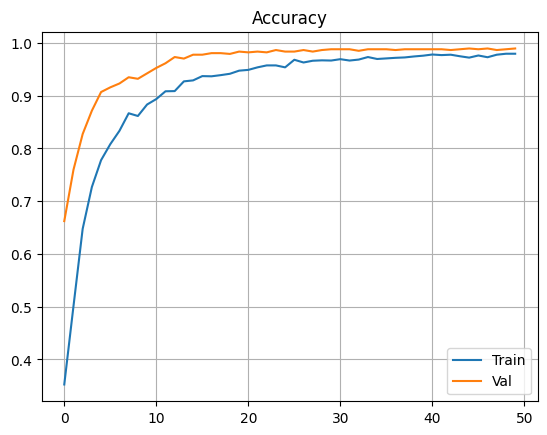

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

         acc       0.98      1.00      0.99       363
        good       1.00      1.00      1.00       363
       unacc       1.00      0.98      0.99       363
       vgood       1.00      1.00      1.00       363

    accuracy                           0.99      1452
   macro avg       0.99      0.99      0.99      1452
weighted avg       0.99      0.99      0.99      1452



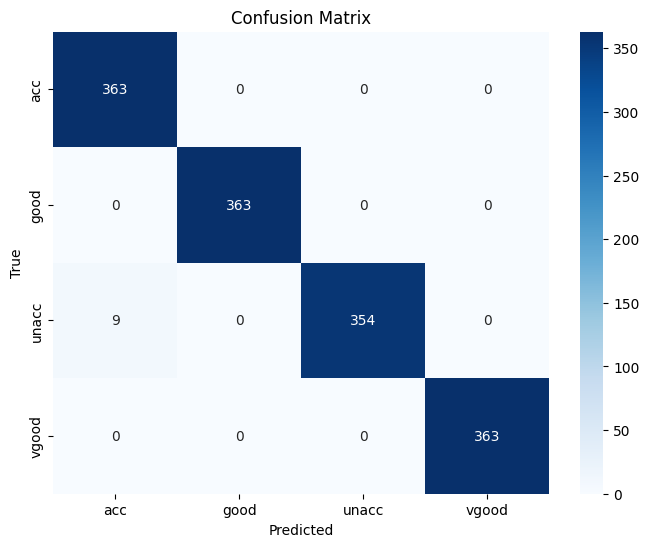

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# График
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Предсказания
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Текстовые метки
class_labels = class_encoder.inverse_transform([0, 1, 2, 3])
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_labels))

# Матрица
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


(g) Веб сервис

Импортируем библиотеки

In [7]:
!pip install flask tensorflow joblib pyngrok --quiet
from flask import Flask, request, render_template_string
from pyngrok import ngrok
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import os
os.system("ngrok config add-authtoken 2yDppIzU2HFVnXKhl7sITZpUHoW_4oPMcEGyQR8AJHFF1Nm98")

0

Загрузим нашу модель

In [8]:
# Загрузка компонентов
model = tf.keras.models.load_model("models/car_classification_model.h5")
scaler = joblib.load("models/scaler.pkl")
class_encoder = joblib.load("models/class_encoder.pkl")
feature_columns = joblib.load("models/feature_columns.pkl")

In [ ]:
app = Flask(__name__)

form_html = '''
<!DOCTYPE html>
<html>
<head><title>Оценка автомобиля</title></head>
<body>
  <h2>Введите параметры автомобиля</h2>
  <form action="/predict" method="post">
    Buying: <select name="buying">
      <option value="vhigh">vhigh</option>
      <option value="high">high</option>
      <option value="med">med</option>
      <option value="low">low</option>
    </select><br>
    Maint: <select name="maint">
      <option value="vhigh">vhigh</option>
      <option value="high">high</option>
      <option value="med">med</option>
      <option value="low">low</option>
    </select><br>
    Doors: <select name="doors">
      <option value="2">2</option>
      <option value="3">3</option>
      <option value="4">4</option>
      <option value="5more">5more</option>
    </select><br>
    Persons: <select name="persons">
      <option value="2">2</option>
      <option value="4">4</option>
      <option value="more">more</option>
    </select><br>
    Lug_boot: <select name="lug_boot">
      <option value="small">small</option>
      <option value="med">med</option>
      <option value="big">big</option>
    </select><br>
    Safety: <select name="safety">
      <option value="low">low</option>
      <option value="med">med</option>
      <option value="high">high</option>
    </select><br><br>
    <input type="submit" value="Предсказать">
  </form>
</body>
</html>
'''

result_html = '''
<!DOCTYPE html>
<html>
<head><title>Результат</title></head>
<body>
  <h2>Класс автомобиля: {{ prediction }}</h2>
  <p>Вероятности:</p>
  <ul>
    {% for label, prob in probs %}
      <li>{{ label }}: {{ prob }}</li>
    {% endfor %}
  </ul>
  <a href="/">Назад</a>
</body>
</html>
'''

@app.route('/')
def home():
    return render_template_string(form_html)

@app.route('/predict', methods=['POST'])
def predict():
    input_dict = {
        'buying': request.form['buying'],
        'maint': request.form['maint'],
        'doors': request.form['doors'],
        'persons': request.form['persons'],
        'lug_boot': request.form['lug_boot'],
        'safety': request.form['safety']
    }

    input_df = pd.DataFrame([input_dict])
    input_encoded = pd.get_dummies(input_df)
    input_encoded = input_encoded.reindex(columns=feature_columns, fill_value=0)
    input_scaled = scaler.transform(input_encoded)

    prediction = model.predict(input_scaled)
    predicted_class = np.argmax(prediction)
    class_name = class_encoder.inverse_transform([predicted_class])[0]

    prob_list = [(class_encoder.inverse_transform([i])[0], f"{p*100:.2f}%") for i, p in enumerate(prediction.flatten())]

    return render_template_string(result_html, prediction=class_name, probs=prob_list)

# Запуск
public_url = ngrok.connect(5000)
print("Веб-приложение доступно по ссылке:", public_url)
app.run()

Веб-приложение доступно по ссылке: NgrokTunnel: "https://a5df-35-247-151-154.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [08/Jun/2025 11:40:23] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jun/2025 11:40:24] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


INFO:werkzeug:127.0.0.1 - - [08/Jun/2025 11:40:36] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jun/2025 11:40:39] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [08/Jun/2025 11:40:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jun/2025 11:40:53] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [08/Jun/2025 11:41:03] "POST /predict HTTP/1.1" 200 -


In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
!mkdir -p /content/drive/MyDrive/car_classifier_project/models


In [11]:
# Копируем кодовые файлы
!cp app.py /content/drive/MyDrive/car_classifier_project/
!cp Dockerfile /content/drive/MyDrive/car_classifier_project/
!cp docker-compose.yaml /content/drive/MyDrive/car_classifier_project/
!cp requirements.txt /content/drive/MyDrive/car_classifier_project/
!cp car_evaluation.csv /content/drive/MyDrive/car_classifier_project/

# Копируем модели
!cp models/*.pkl /content/drive/MyDrive/car_classifier_project/models/
!cp models/*.keras /content/drive/MyDrive/car_classifier_project/models/


cp: cannot stat 'models/*.keras': No such file or directory
